# Computer Vision technique
In this notebook we continue with some Computer Vision technique that helps in detecting lane-line task

* Gradient threshold with Sobol operator
* Color threshold

First let's import some modules

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

# Read in an image
#input_img = './assets/signs_vehicles_xygrad.png'
input_img = './assets/frame_01045.png'
image = mpimg.imread(input_img)

## Gradient threshold with Sobol operator
In the previous notebook, we try Canny line detection which is quite useful for lane-line dection. Note that Canny line detection is a bit noisy and it collects un-useful information. 

In this part, we look at Sobol operator which allows us to compute gradient in each direction x and y. And we can use the fact that lane line should be closed to a straight line in order to detect lane line.

### Absolute threshold
We implement a function to apply filter on gradient of a specific orientation

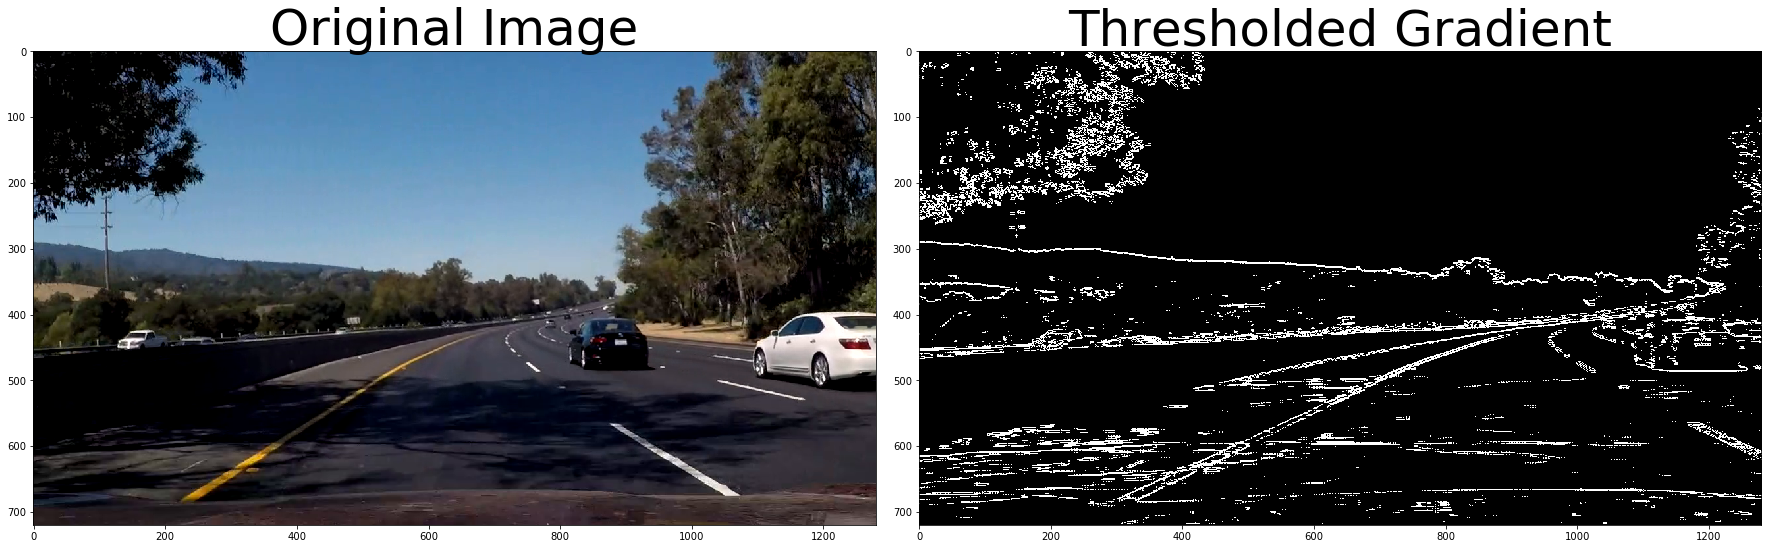

In [2]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh = (0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255. * sobel / np.max(sobel))
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

# Run the function
grad_binary = abs_sobel_thresh(image, orient='y', thresh=(20, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

###  Magnitute threshold
Next we implement a function that do the threshold on sqrt(sobelx^2 + sobely^2)

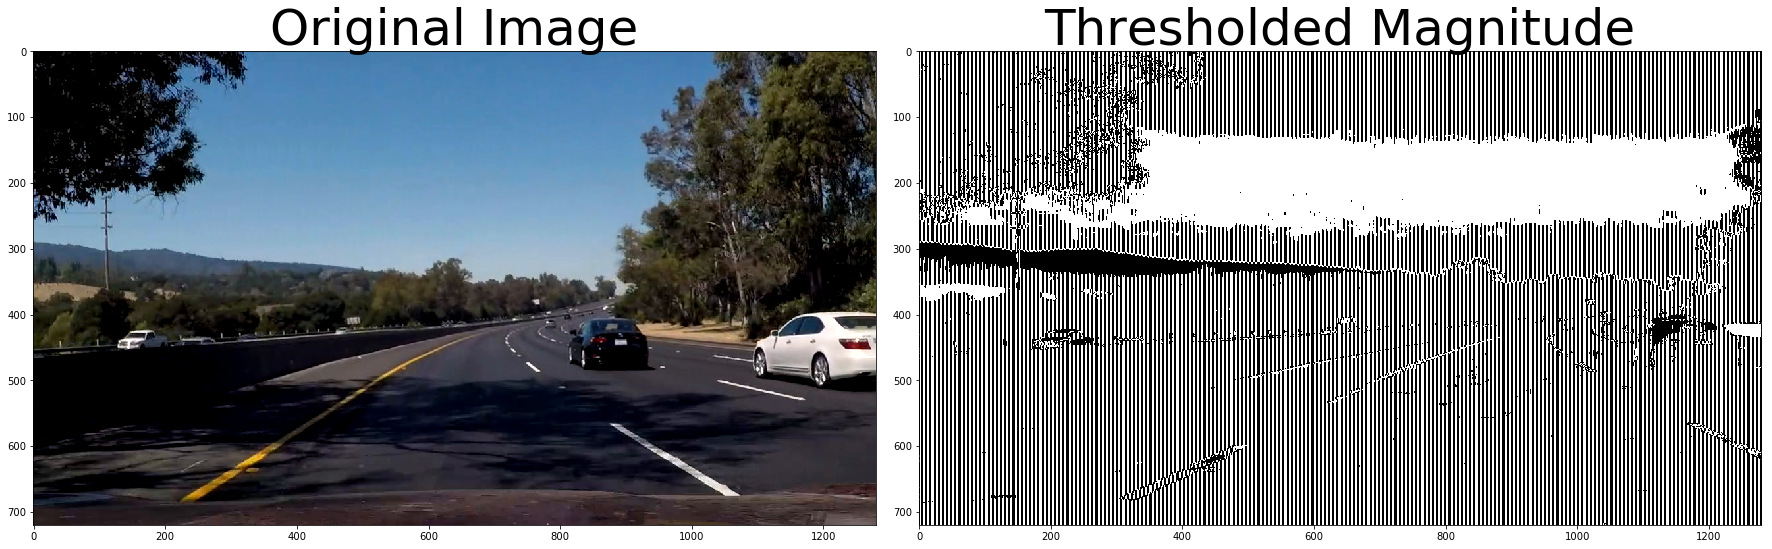

In [3]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # AColor(im, cv2.COLOR_RGB2GRAY)pply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    magn = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_magn = np.uint8(255*magn/np.max(magn))
    
    binary_output = np.zeros_like(magn)
    binary_output[(scaled_magn >= mag_thresh[0]) & (scaled_magn <= mag_thresh[1])] = 1
    
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Direction threshold
We can use `np.arctan2` to get the angle of the line then filter on the angle

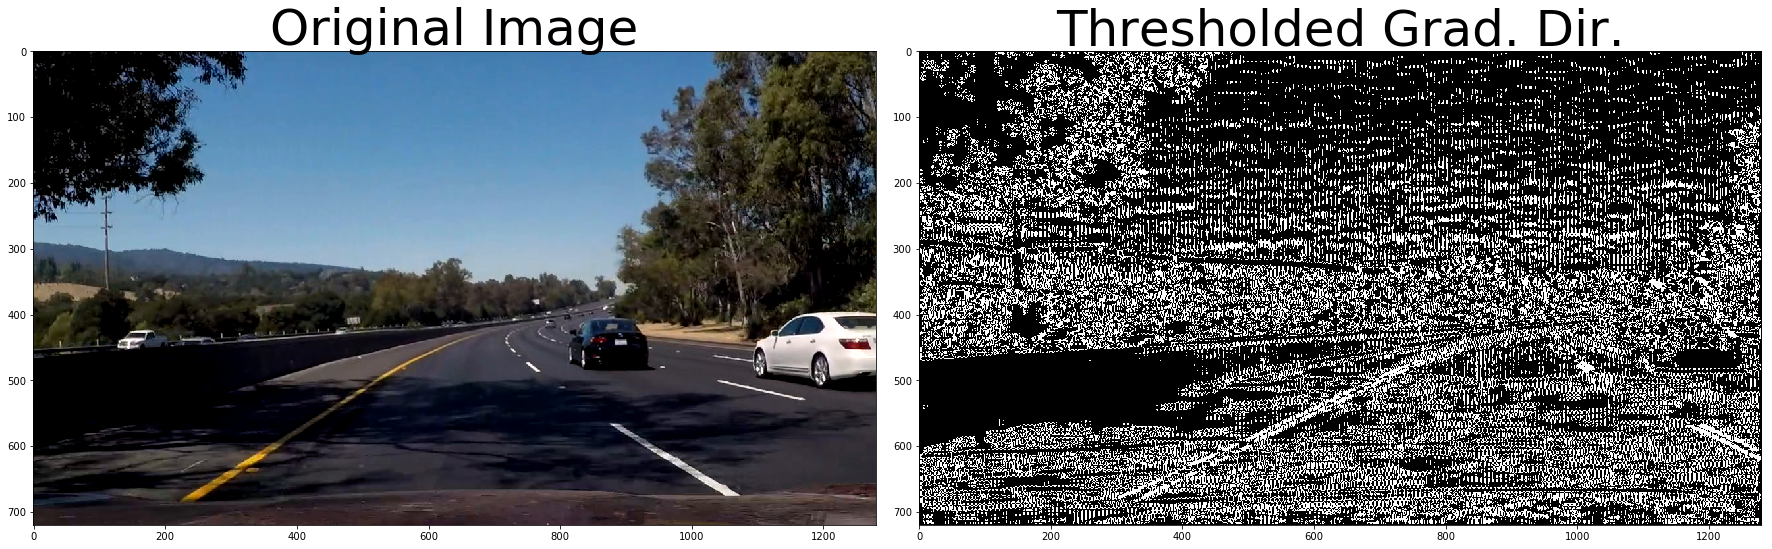

In [4]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.abs(sobely), np.abs(sobelx))
    
    binary_output = np.zeros_like(absgraddir)
    
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combined technique
Let's combine the three above functions

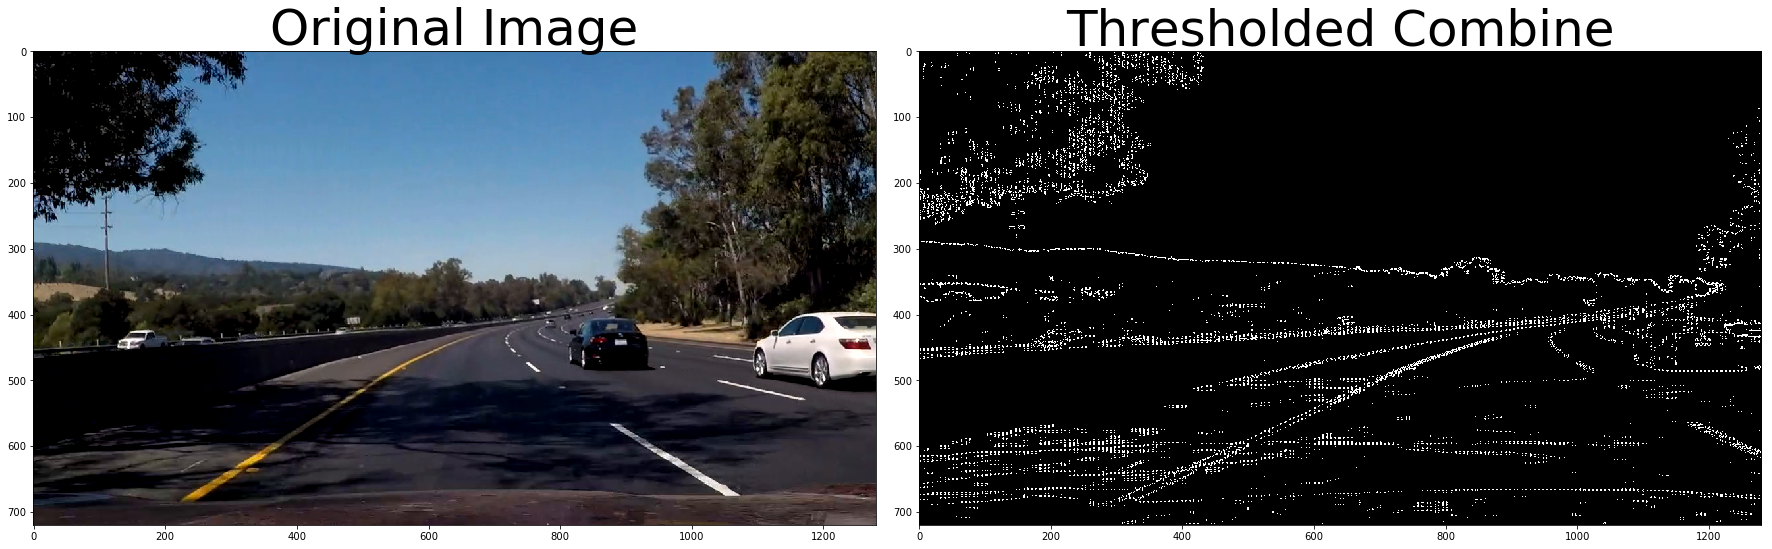

In [5]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Combine', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color threshold
In the first notebook, we transform image into grayscale before detecting lane-line, however in making this transformation we lose valuable color information. 

For example, extracting image from the clip `challenge.mp4`

In [12]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('./CarND-P1-LaneLines/test_videos/challenge.mp4')
i = 0
for frame in clip.iter_frames():
    mpimg.imsave('./assets/lane_lines/cf_{:d}.png'.format(i), frame)
    i += 1

Looking at the frame 140 (we copied it to `lane_line.png`), we can see that in gray-scale color-space the yellow lane-line is almost disappears

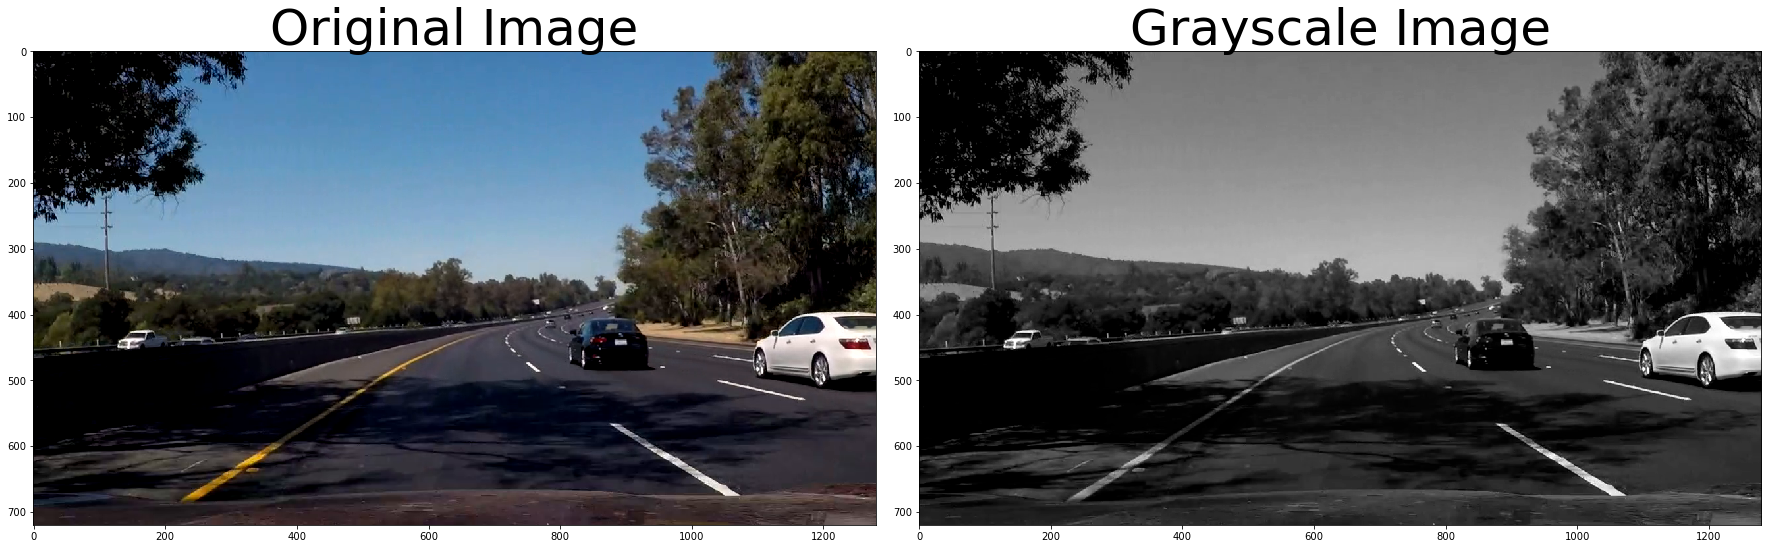

In [7]:
#input_img = './assets/lane_line.png'
input_img = './assets/frame_01045.png'
img = cv2.imread(input_img)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rgb)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gray, cmap='gray')
ax2.set_title('Grayscale Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In this section, we investigate other color spaces which give us more information about image than grayscale alone so that we can get back the yellow line.

### HSV and HLS color spaces
HSV stands for hue, saturation and brightness and HLS stands for hue, lightness and saturation, for both color spaces H has a range from 0 to 179.

For HLS we have

* L isolates the lightness which varies the most under different lightning condition
* H, S stay fairy consistent in shadow or excessive brightness

So if we use H and S of HLS we should be able to detect lane line in **diffrent lightning condition** more reliable than RGB. Let's visualize the above image in HLS color-space.

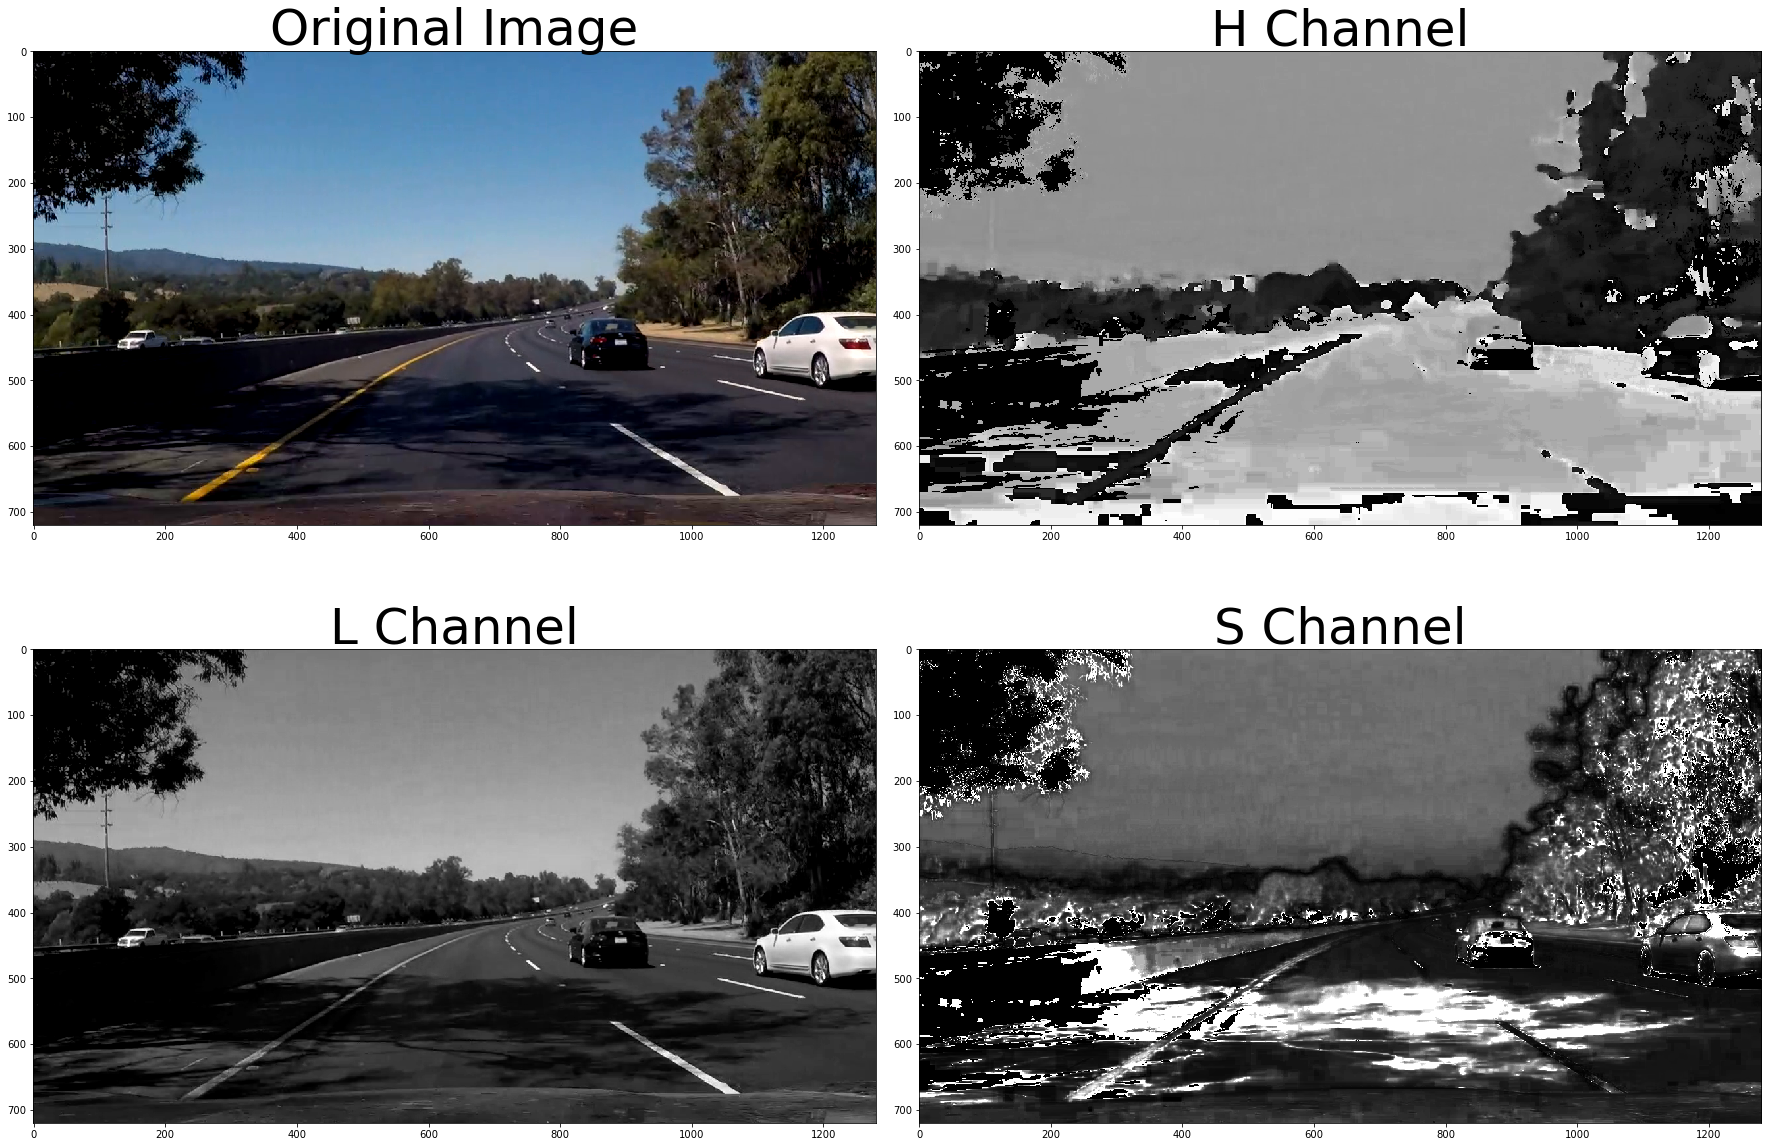

In [8]:
def view_hls(bgr_img):
    rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HLS)
    
    f, axes = plt.subplots(2, 2, figsize=(24, 18))
    f.tight_layout()
    (ax1, ax2, ax3, ax4) = axes.flatten()
    ax1.imshow(rgb)
    ax1.set_title('Original Image', fontsize=50)
    hls_axes = [ax2, ax3, ax4]
    channels = ['H', 'L', 'S']
    for i,c in enumerate(channels):
        hls_axes[i].imshow(hls[:,:,i], cmap='gray')
        hls_axes[i].set_title('{} Channel'.format(c), fontsize=50)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
view_hls(img)

From the above visualization, it looks like the S channel detects lane line pretty well.

Now let's implement color threshold using different color space

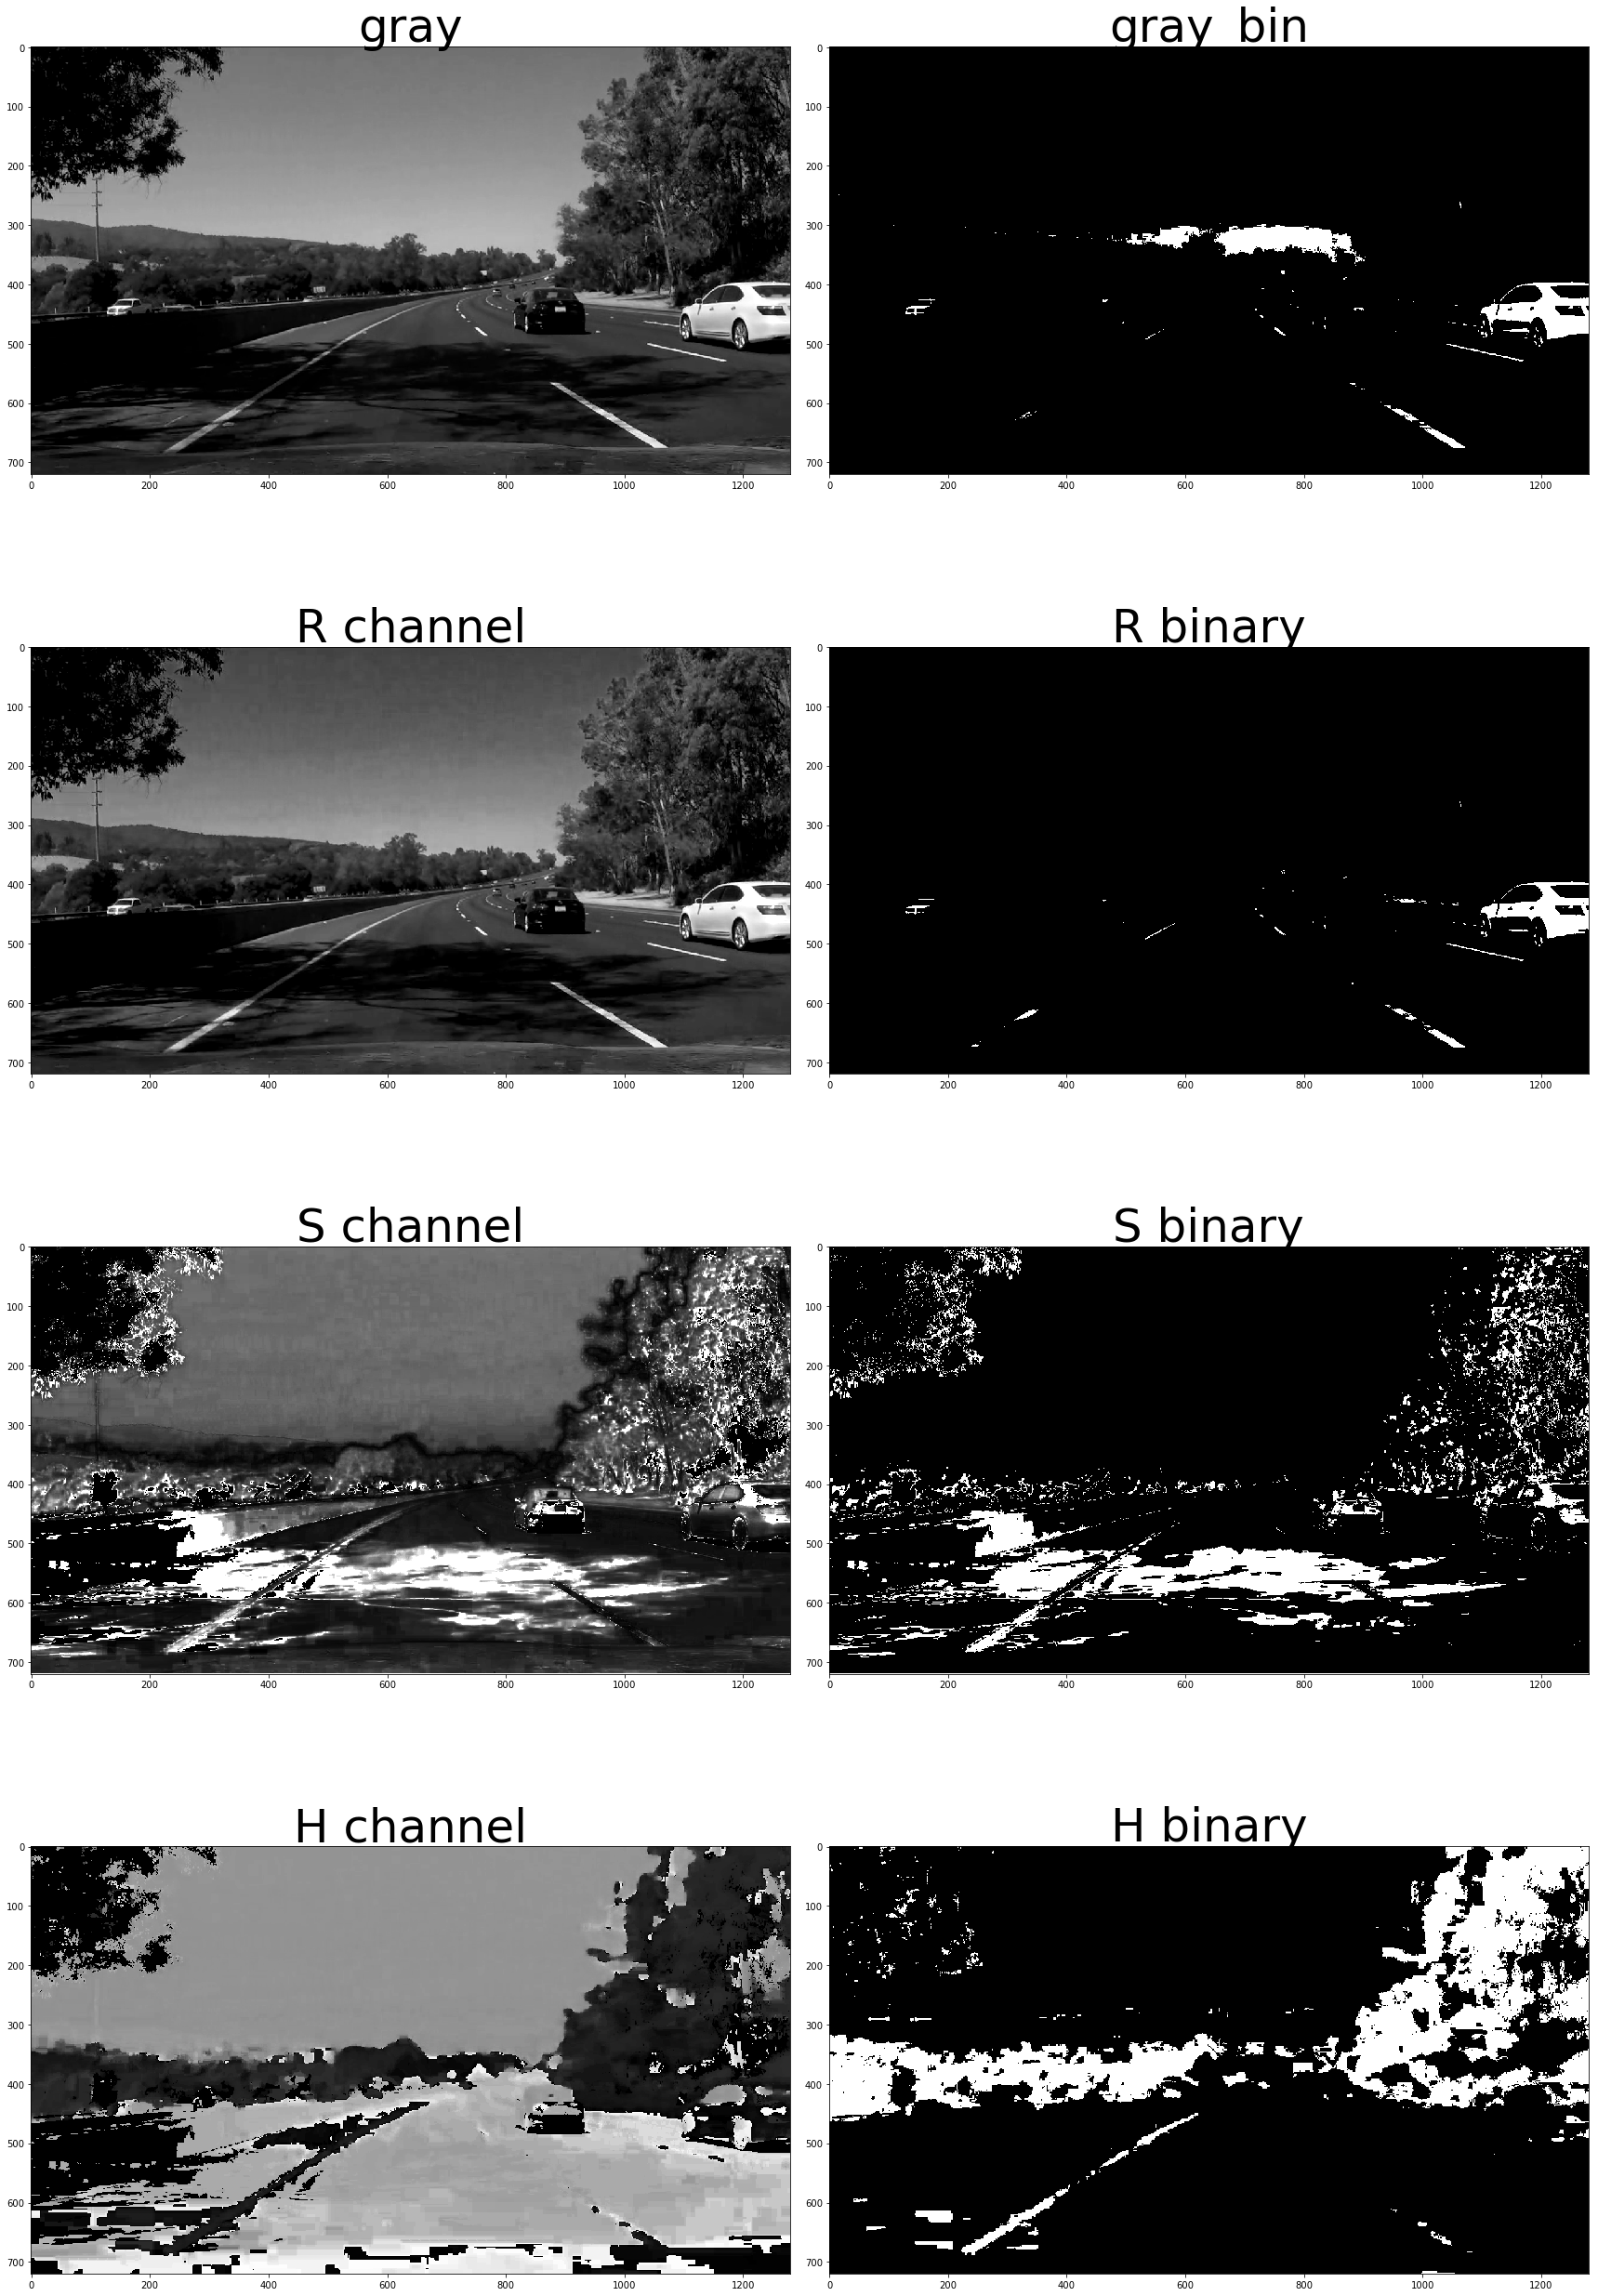

In [10]:
def color_thresh(img, thresh = (0,255)):
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary
    
def view_color_thresh(bgr_img, 
                      gray_thresh = (180, 255),
                      r_thresh = (200, 255),
                      s_thresh = (150, 255),
                      h_thresh = (15, 100)
                     ):
    # gray image
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    
    # gray binary
    gray_bin = color_thresh(gray, gray_thresh)
    
    # red binary
    rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    r_bin = color_thresh(rgb[:,:,0], r_thresh)
    
    # hls image
    hls = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HLS)
    
    # H & S binary
    s_bin = color_thresh(hls[:,:,2], s_thresh)
    h_bin = color_thresh(hls[:,:,0], h_thresh)
    
    imgs   = [gray, gray_bin, bgr_img[:,:,2], r_bin, hls[:,:,2], s_bin, hls[:,:,0], h_bin]
    labels = ['gray', 'gray_bin', 'R channel', 'R binary', 'S channel', 'S binary', 'H channel', 'H binary']
    f, axes = plt.subplots(4, 2, figsize=(24, 36))
    f.tight_layout()
    
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i], cmap='gray')
        ax.set_title(labels[i], fontsize=50)

view_color_thresh(img)

Looking at above visualization, we can see that R and S are better than the other. However when we test with other image, we found that S is more stable in different lightning condition

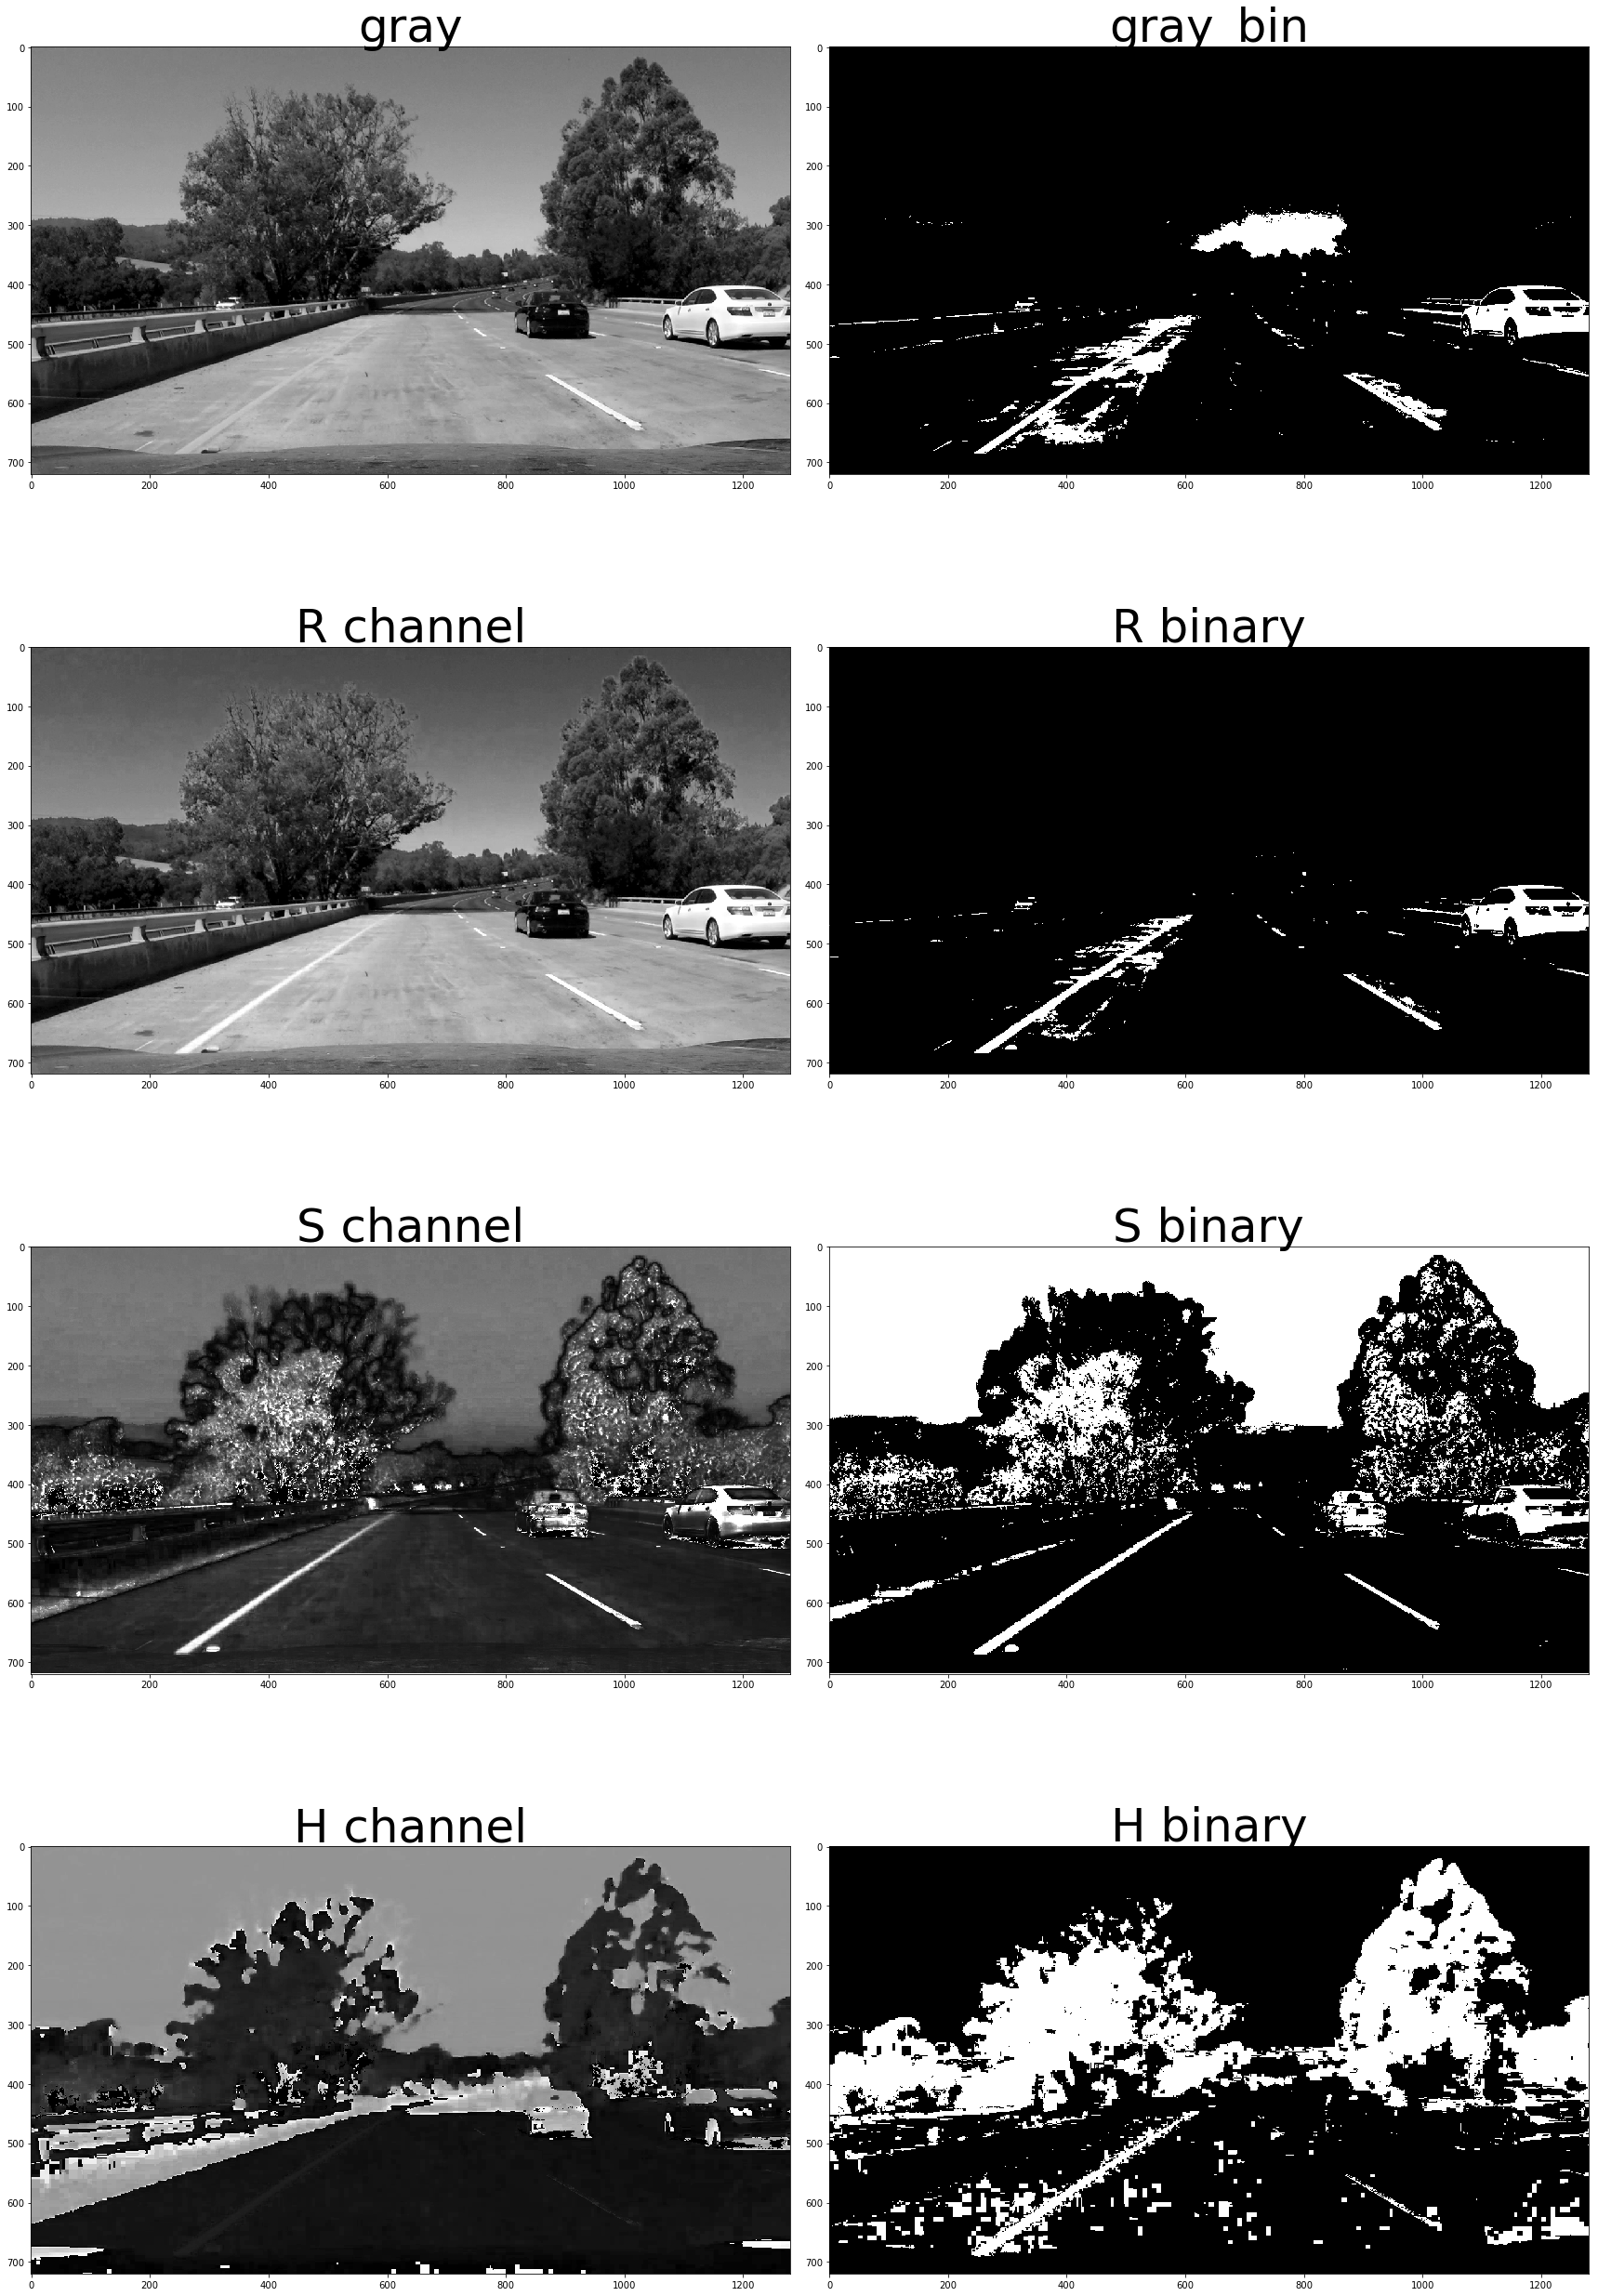

In [41]:
img2 = cv2.imread('./assets/lane_line2.png')
view_color_thresh(img2)